# Data Visualization - Bay Wheels Trip Data

In this project, we shall perform exploratory and explanatory visualization on the [Bay Wheels Trip Data](https://www.lyft.com/bikes/bay-wheels/system-data) provided by Lyft. We use the latest version of the data available (for March 2020, generated on April 18th). First, we download and load the data in a pandas DataFrame and perform some preliminary data wrangling.

## Preliminary Data Wrangling

In [4]:
# Importing packages needed and setting visibility for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import zipfile

% matplotlib inline

In [5]:
# Getting the file from the website
dataset_url = "https://s3.amazonaws.com/baywheels-data/202003-baywheels-tripdata.csv.zip"
req = requests.get(dataset_url)
file_name = dataset_url.split('/')[-1]

In [ ]:
# Downloading file in ZIP format
open(file_name, 'wb').write(req.content)

In [6]:
# Extracting ZIP file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
data_file = file_name.replace('.zip', '')

In [7]:
# Reading file into pandas and having a look at it
trip_data_df = pd.read_csv(data_file)
trip_data_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method
0,35187,2020-03-31 20:42:10.0790,2020-04-01 06:28:37.8440,462.0,Cruise Terminal at Pier 27,37.804648,-122.402087,24.0,Spear St at Folsom St,37.789677,-122.390428,10982,Customer,NaN
1,14568,2020-03-31 22:45:25.5010,2020-04-01 02:48:13.7730,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,370.0,Jones St at Post St,37.787327,-122.413278,12617,Customer,NaN
2,35990,2020-03-31 15:08:22.3310,2020-04-01 01:08:12.9900,391.0,1st St at Younger Ave,37.355030,-121.904436,397.0,Gish Rd at 1st St,37.361867,-121.909315,12812,Customer,NaN
3,1068,2020-03-31 23:55:00.4260,2020-04-01 00:12:49.0200,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN
4,3300,2020-03-31 23:00:55.6410,2020-03-31 23:55:56.6110,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,24.0,Spear St at Folsom St,37.789677,-122.390428,13050,Customer,NaN


In [8]:
trip_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 14 columns):
duration_sec               176799 non-null int64
start_time                 176799 non-null object
end_time                   176799 non-null object
start_station_id           110696 non-null float64
start_station_name         111349 non-null object
start_station_latitude     176799 non-null float64
start_station_longitude    176799 non-null float64
end_station_id             111097 non-null float64
end_station_name           111794 non-null object
end_station_latitude       176799 non-null float64
end_station_longitude      176799 non-null float64
bike_id                    176799 non-null int64
user_type                  176799 non-null object
rental_access_method       114269 non-null object
dtypes: float64(6), int64(2), object(6)
memory usage: 18.9+ MB


From the [Lyft's data source page](https://www.lyft.com/bikes/bay-wheels/system-data), we understand that this data is anonymized, and we only have the identifier for the bike used for a particular trip. Each row represents a trip. The columns `start_time` and `end_time` denote the date and the time when the trip was started or ended respectively. Let us convert these columns to a datetime object instead of a string object which they are currently in.

In [9]:
# Converting to datetime object
trip_data_df['start_time'] = pd.to_datetime(trip_data_df['start_time'])
trip_data_df['end_time'] = pd.to_datetime(trip_data_df['end_time'])

The `bike_id` should be a string. Let us convert it.

In [10]:
# Converting to string
trip_data_df['bike_id'] = trip_data_df['bike_id'].astype(str)

The field `user_type` describes whether the user is a Subscriber (regular user subscribed to Bay Wheels), or a Customer (casual user/possibly one-time user). This type of variable is more suited for an ordered categorical type. Let us convert it as such.

In [11]:
# Converting to category
trip_data_df['user_type'] = trip_data_df['user_type'].astype('category')
trip_data_df['user_type'].cat.reorder_categories(['Customer', 'Subscriber'], inplace=True)

The field `rental_access_method` denotes whether the bike was accessed using the app or by using a 'Clipper' card. Let us convert this into a categorical variable.

In [12]:
trip_data_df['rental_access_method'] = trip_data_df['rental_access_method'].astype('category')

There are some missing values in the IDs and names of the start/end stations, but they do have their lattitude and longitude values, which we can use for further analysis. Also, not all values for the rental access method are available. There is no way we can obtain this data, so let us take a note of this for now and proceed to the next step.

Let us add new columns for the time of day (morning, afternoon, evening, or night) for both the start and end dates.

In [13]:
def get_time_of_day(x):
    '''Takes in a pandas datetime object and returns the time of the day'''
    if x.hour >= 6 and x.hour < 12:
        return 'morning'
    elif x.hour >= 12 and x.hour < 17:
        return 'afternoon'
    elif x.hour >= 17 and x.hour < 20:
        return 'evening'
    else:
        return 'night'

In [14]:
# Creating a categorical column for start and end time of day
trip_data_df['start_time_of_day'] = trip_data_df['start_time'].apply(get_time_of_day).astype('category').cat.reorder_categories(['morning', 'afternoon', 'evening', 'night'])
trip_data_df['end_time_of_day'] = trip_data_df['end_time'].apply(get_time_of_day).astype('category').cat.reorder_categories(['morning', 'afternoon', 'evening', 'night'])

The following is how the wrangled data looks like.

In [15]:
trip_data_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method,start_time_of_day,end_time_of_day
0,35187,2020-03-31 20:42:10.079,2020-04-01 06:28:37.844,462.0,Cruise Terminal at Pier 27,37.804648,-122.402087,24.0,Spear St at Folsom St,37.789677,-122.390428,10982,Customer,NaN,night,morning
1,14568,2020-03-31 22:45:25.501,2020-04-01 02:48:13.773,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,370.0,Jones St at Post St,37.787327,-122.413278,12617,Customer,NaN,night,night
2,35990,2020-03-31 15:08:22.331,2020-04-01 01:08:12.990,391.0,1st St at Younger Ave,37.355030,-121.904436,397.0,Gish Rd at 1st St,37.361867,-121.909315,12812,Customer,NaN,afternoon,night
3,1068,2020-03-31 23:55:00.426,2020-04-01 00:12:49.020,456.0,Arguello Blvd at Geary Blvd,37.781468,-122.458806,107.0,17th St at Dolores St,37.763015,-122.426497,12955,Customer,NaN,night,night
4,3300,2020-03-31 23:00:55.641,2020-03-31 23:55:56.611,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,24.0,Spear St at Folsom St,37.789677,-122.390428,13050,Customer,NaN,night,night


In [16]:
trip_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 16 columns):
duration_sec               176799 non-null int64
start_time                 176799 non-null datetime64[ns]
end_time                   176799 non-null datetime64[ns]
start_station_id           110696 non-null float64
start_station_name         111349 non-null object
start_station_latitude     176799 non-null float64
start_station_longitude    176799 non-null float64
end_station_id             111097 non-null float64
end_station_name           111794 non-null object
end_station_latitude       176799 non-null float64
end_station_longitude      176799 non-null float64
bike_id                    176799 non-null object
user_type                  176799 non-null category
rental_access_method       114269 non-null category
start_time_of_day          176799 non-null category
end_time_of_day            176799 non-null category
dtypes: category(4), datetime64[ns](2), float64(6), int64(1)

### How is the dataset structured?
The data contains information about 176799 rides generated in the month of April for March 2020. The following are the variables in the dataset.

- **duration_sec** - Duration of the ride (in seconds)
- **start_time** - Date and time when the ride was initiated
- **end_time** - Date and time when the ride was completed
- **start_station_id** - Identifier of the bike station where the ride was initiated
- **start_station_name** - Name of the bike station where the ride was initiated
- **start_station_latitude** - Latitude of the bike station where the ride was initiated
- **start_station_longitude** - Longitude of the bike station where the ride was initiated
- **end_station_id** - Identifier of the bike station where the ride was completed
- **end_station_name** - Name of the bike station where the ride was completed
- **end_station_latitude** - Latitude of the bike station where the ride was completed
- **end_station_longitude** - Longitude of the bike station where the ride was completed
- **bike_id** - Identifier of the bike
- **user_type** - Whether the user is a Subscriber (regular user) or a Customer (casual user)
    - Category variable with values 'Customer' and 'Subscriber'
    - Importance from Customer to Subscriber (Customer being the least important)
- **rental_access_method** - The method which the user used to access the bike (via the app or the Clipper card)
    - Category variable with values 'app' and 'clipper'
    - No importance assigned to values
- **start_time_of_day** - Derived from _start_time_, denotes the period of day of the _start_time_ attribute
    - Category variable with values 'morning', 'afternoon', 'evening', and 'night'.
    - Importance from early to late in the order 'morning', 'afternoon', 'evening', 'night'
- **end_time_of_day** - Derived from _end_time_, denotes the period of day of the _end_time_ attribute
    - Category variable with values 'morning', 'afternoon', 'evening', and 'night'.
    - Importance from early to late in the order 'morning', 'afternoon', 'evening', 'night'

### What are the main features of interest?
- Do the subscribers have the longest rides or casual customers? Do app users ride longer than Clipper ones?
    - Analyzing this could help us identify what kind of customers bring in the most revenue.
- Which are the most frequently used bikes? Which stations have the most used bikes?
    - Identifying this helps us maintain and repair the bikes to mitigate wear and tear and provide customers high-quality bikes.
- How many customers travel, and which category do they fall (subscribers or customers) and at what time of the day?

### What are the useful features in the dataset that can be used to describe the main features of interest?
- The `duration_sec` column would help identify the length of the ride.
- `user_type` and `rental_access_method` would help classify customers.
- `bike_id` and the station variables would help identify bikes and stations respectively.
- `start_time_of_day` and `end_time_of_day` is useful for grouping customers by the time of the day of starting and ending rides.

## Univariate Exploratory Analysis

Let us explore the distribution of `duration_sec`.

In [17]:
trip_data_df['duration_sec'].describe()

count    176799.000000
mean        861.590156
std        1528.143090
min          60.000000
25%         374.000000
50%         602.000000
75%         963.000000
max       84450.000000
Name: duration_sec, dtype: float64

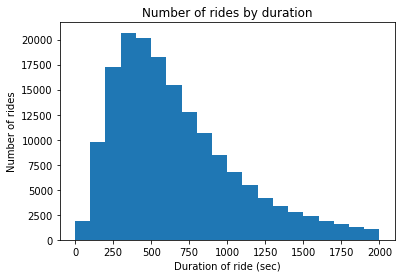

In [18]:
# Plotting histogram without outliers based on above description
bins = np.arange(0, 2000 + 100, 100)
plt.hist(trip_data_df['duration_sec'], bins=bins)
plt.xlabel('Duration of ride (sec)')
plt.ylabel('Number of rides')
plt.title('Number of rides by duration');

The distribution is right-skewed. It seems that most people take very short rides (250-500 seconds), which is about 4 to 8 minutes. The longest ride was for 84450 seconds, which is almost 23 and a half hours! Somebody took a bike for an entire day!

Let us see how this looks like in a box plot.

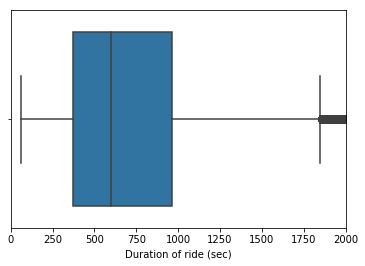

In [19]:
# Plotting boxplot without outliers
sb.boxplot(trip_data_df['duration_sec'])
plt.xlim((0, 2000))
plt.xlabel('Duration of ride (sec)');

The mean is at about 600 seconds, or 10 minutes. The majority of the rides are for a short period.

Let us explore the categorical variables `user_type` and `rental_access_method`.

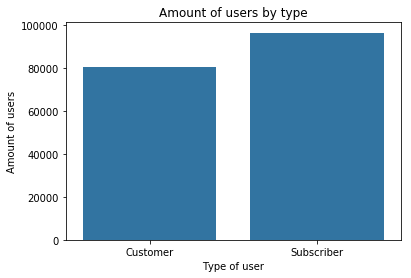

In [20]:
# Plotting count plot based on user type
color = sb.color_palette()[0]
sb.countplot(trip_data_df['user_type'], color=color)
plt.xlabel('Type of user')
plt.ylabel('Amount of users')
plt.title('Amount of users by type');

There are more subscribers than customers in this dataset.

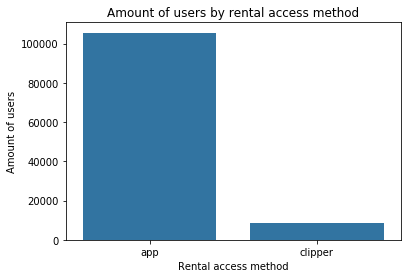

In [21]:
# Plotting count plot based on rental access method of customer
color = sb.color_palette()[0]
sb.countplot(trip_data_df['rental_access_method'], color=color)
plt.xlabel('Rental access method')
plt.ylabel('Amount of users')
plt.title('Amount of users by rental access method');

We can see that the vast majority of the customers use the app to ride. Clipper Cards are not very popular.

Let us now see the top ten used bikes by bike ID.

In [22]:
# Calculating popular bikes
popular_bikes = trip_data_df['bike_id'].value_counts()[:10].reset_index()
popular_bikes.columns = ['bike_id', 'count']
popular_bikes = popular_bikes.sort_values('count', ascending=False)
popular_bikes

,bike_id,count
0,400679,124
1,572289,107
2,329859,103
3,758330,100
4,467444,100
5,555435,99
6,406817,98
7,365978,97
8,956776,97
9,535738,96


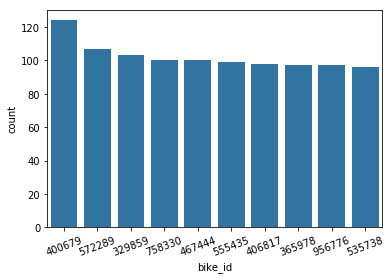

In [23]:
# Plotting bar chart for the above
color = sb.color_palette()[0]
plt.xticks(rotation=20)
sb.barplot(data = popular_bikes, x = 'bike_id', y = 'count', color = color, order = popular_bikes['bike_id']);

This does not really give us more information. Let us check this by end station names instead to identify which stations are started with and ended up with the most bikes.

In [24]:
# Calculating popular stations by start time
popular_bikes = trip_data_df['start_station_name'].value_counts()[:10].reset_index()
popular_bikes.columns = ['start_station_name', 'count']
popular_bikes = popular_bikes.sort_values('count', ascending=False)
popular_bikes

,start_station_name,count
0,San Francisco Caltrain (Townsend St at 4th St),1910
1,Market St at 10th St,1851
2,Market St at Steuart St,1446
3,Berry St at 4th St,1414
4,Powell St BART Station (Market St at 4th St),1306
5,Howard St at Beale St,1158
6,Montgomery St BART Station (Market St at 2nd St),1116
7,Powell St BART Station (Market St at 5th St),1100
8,San Francisco Ferry Building (Harry Bridges Pl...,951
9,Rhode Island St at 17th St,909


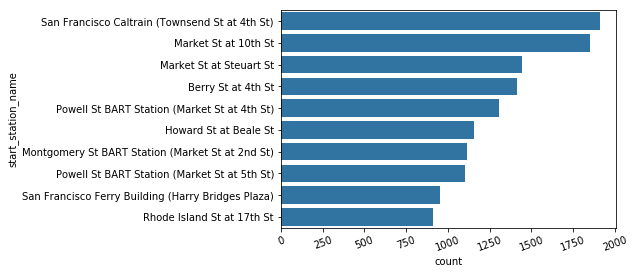

In [25]:
# Plotting bar chart for the above
color = sb.color_palette()[0]
plt.xticks(rotation=20)
sb.barplot(data = popular_bikes, y = 'start_station_name', x = 'count', color = color, order = popular_bikes['start_station_name']);

In [26]:
# Calculating popular stations by end time
popular_bikes = trip_data_df['end_station_name'].value_counts()[:10].reset_index()
popular_bikes.columns = ['end_station_name', 'count']
popular_bikes = popular_bikes.sort_values('count', ascending=False)
popular_bikes

,end_station_name,count
0,San Francisco Caltrain (Townsend St at 4th St),2796
1,Montgomery St BART Station (Market St at 2nd St),2024
2,Market St at 10th St,1909
3,Berry St at 4th St,1527
4,Powell St BART Station (Market St at 4th St),1527
5,Market St at Steuart St,1514
6,San Francisco Ferry Building (Harry Bridges Pl...,1267
7,Powell St BART Station (Market St at 5th St),1116
8,Howard St at Beale St,1085
9,Rhode Island St at 17th St,975


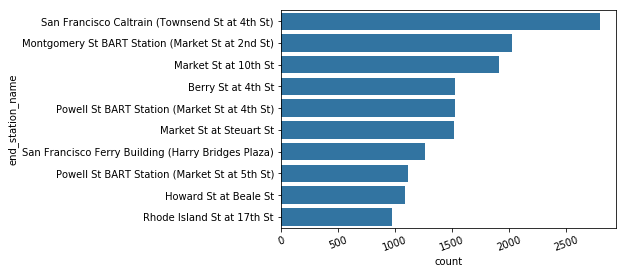

In [27]:
# Plotting bar chart for the above
color = sb.color_palette()[0]
plt.xticks(rotation=20)
sb.barplot(data = popular_bikes, y = 'end_station_name', x = 'count', color = color, order = popular_bikes['end_station_name']);

We can see that the San Francisco Caltrain station has significantly high (a bit below 3000) end rides in the month of March. It is also the most popular station for starting rides. This is the station we must focus the most on for maintaining bikes. Interestingly, the Market St. at 10th St. station is a close second for starting rides.

### Did you find any points of interest?
- It seems that the majority of customers do not use the service for long rides. Most of the rides are for a short period (4-8 minutes).
- There are more subscribers than one-time customers.
- The overwhelming majority of the rides were accessed through the app as opposed to Clipper Cards.
- The bike station 'San Francisco Caltrain' is overwhelmingly popular for starting and ending rides.

###  Did you find any unusual attributes in the data?
- There was one ride that was taken for almost one entire day.

## Bivariate Exploratory Analysis

Let us look at the count of the duration of rides by user type.

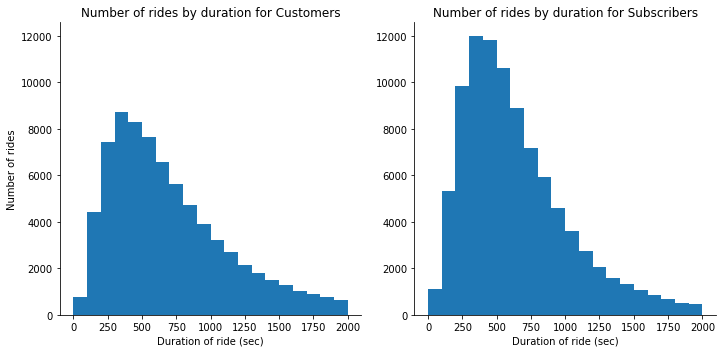

In [28]:
# Plotting faceted histogram for duration and type of user
g = sb.FacetGrid(data = trip_data_df, col = 'user_type', size=5)
bins = np.arange(0, 2000 + 100, 100)
g.map(plt.hist, 'duration_sec', bins=bins)
axes = g.axes.flatten()
axes[0].set_title("Number of rides by duration for Customers")
axes[1].set_title("Number of rides by duration for Subscribers")
axes[0].set_ylabel("Number of rides")
for ax in axes:
    ax.set_xlabel("Duration of ride (sec)")
plt.plot();

Here, we observe that the distribution is about the same, but with a longer peak for subscribers compared to customers. There are a higher number of subscribers than customers, as observed in the univariate bar plot done for these two categories earlier, which could explain the peak for subscribers.

Let us perform the above for rental access method as well.

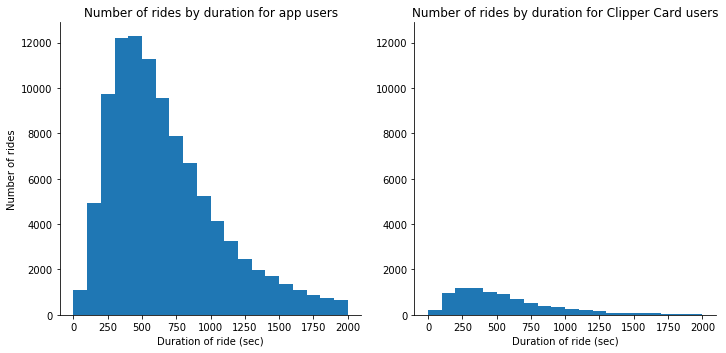

In [29]:
# Plotting faceted histogram for duration and rental access method of customer
g = sb.FacetGrid(data = trip_data_df, col = 'rental_access_method', size=5)
bins = np.arange(0, 2000 + 100, 100)
g.map(plt.hist, 'duration_sec', bins=bins)
axes = g.axes.flatten()
axes[0].set_title("Number of rides by duration for app users")
axes[1].set_title("Number of rides by duration for Clipper Card users")
axes[0].set_ylabel("Number of rides")
for ax in axes:
    ax.set_xlabel("Duration of ride (sec)")
plt.plot();

The amount of Clipper Card users are significantly less than those who use the app. Let us separately plot the Clipper Card users and look at the distribution.

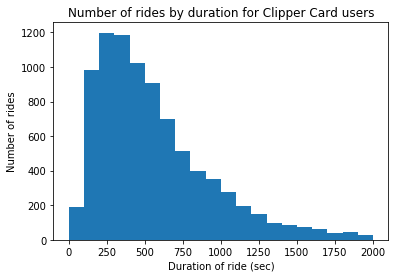

In [30]:
bins = np.arange(0, 2000 + 100, 100)
plt.hist(trip_data_df.query('rental_access_method == "clipper"')['duration_sec'], bins=bins)
plt.xlabel('Duration of ride (sec)')
plt.ylabel('Number of rides')
plt.title('Number of rides by duration for Clipper Card users');

The distribution has the same shape, regardless of whether the customer uses an app or a Clipper Card, or whether the customer is a subscriber. There is no evidence to suggest that any of these customers exhibit different patterns.

### Did you find any points of interest?
- All kinds of customers follow the same distribution, no matter whether they are subscribers or customers or use the app or the Clipper card. Everybody uses Bay Wheels for short rides.

###  Did you find any unusual attributes in the data?
- We would usually expect different segments of customers to exhibit different behaviour, but in this case, being a subscriber or a card user does not seem to impact the behaviour of most customers. Everybody seems to be following the same distribution.

## Multivariate Exploratory Analysis

Let us explore the remaining question: How many customers travel, and which category do they fall (subscribers or customers) and at what time of the day?

Multivariate analysis is useful for this, as we are analyzing data across four dimensions: the amount of customers, the type of customer, the time of the day for starting, and for ending the ride.

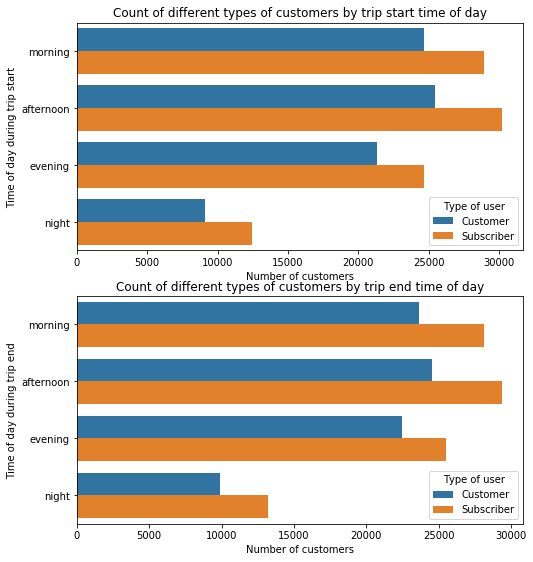

In [31]:
# Plotting clustered bar charts for the above four variables
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(2, 1, 1)
sb.countplot(data=trip_data_df, y='start_time_of_day', hue='user_type')
plt.subplots_adjust(bottom=0.01)
ax.set_title('Count of different types of customers by trip start time of day')
ax.set_xlabel('Number of customers')
ax.set_ylabel('Time of day during trip start')
plt.legend(title='Type of user')
ax = fig.add_subplot(2, 1, 2)
sb.countplot(data=trip_data_df, y='end_time_of_day', hue='user_type')
ax.set_title('Count of different types of customers by trip end time of day')
ax.set_xlabel('Number of customers')
ax.set_ylabel('Time of day during trip end')
plt.legend(title='Type of user');

Both the graphs show similar distribution. The distribution across the time of the day and the type of customer is roughly the same and is only impacted by the amount of customers in that category.

One observation we can make from the above graph is that any kind of customer is more likely to ride in the afternoon or the morning.

### Did you find any points of interest?
- With respect to the time of the day when the trips are started and ended, the customers exhibit homogeneous behaviour. This follows from the previous bivariate and univariate exploration.
- Customers are more likely to ride in the afternoon rather than other periods of the day. We can use this information to ensure that more bikes are available in afternoons.

###  Did you find any unusual attributes in the data?
- We did not find any different behaviour in different segments of customers. Customer behaviour regardless of their type is similar.